In [1]:
%pylab inline
from jax.scipy import ndimage
from constant import * 
from multiprocessing import Pool
from functools import partial
import warnings
import jax.numpy as jnp
from jax import jit
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


### Value iteration of renting a house

$$V_t(w_t, s_t) = max_{\{c_t, h_t, b_t, k_t\}}\{ u(c_t, h_t) + \beta E[P_t V_{t+1}(w_{t+1}, s_{t+1}) + (1-P_t) u_B(w_{t+1})]\}$$
Subject to:    
$$y_t + w_t = c_t + P_t^r h_t + b_t + k_t$$
$$ w_{t+1} = (1+r_t^f) b_t + (1+r_{t+1}^m) k_t $$    

Shape of the state: $$(100  \times 27)$$
Shape of the actions: $$(20 \times 20 \times 20)$$

In [2]:
nX = Xs.shape[0]
Xs.shape

(2700, 2)

In [3]:
nA = As.shape[0]
As.shape

(8000, 3)

In [4]:
X = jnp.repeat(Xs, nA, axis = 0)
A = jnp.tile(As, (nX,1))

In [5]:
A.shape

(21600000, 3)

In [6]:
X.shape

(21600000, 2)

In [7]:
#Define the utility function
@jit
def u(c):
    return (jnp.power(c, 1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth
@jit
def uB(tb):
    return B*u(tb)

#Reward function for renting
@jit
def u_rent(a):
    '''
    Input:
        action a: c, b, k, h = a
    Output:
        reward value: the length of return should be equal to the length of a
    '''
    c = a[:,0]
    h = a[:,3]
    C = jnp.power(c, alpha) * jnp.power(h, 1-alpha)
    return u(C)
@jit
def transition_to_rent(x,a,t):
    '''
        imput: a is np array constains all possible actions 
        output: from x = w_t to x = w_{t+1}
    '''
    s = jnp.array(x[:,1], dtype = jnp.int16)
    # actions taken 
    b = a[:,1]
    k = a[:,2]
    x_next0 = ((1+r_b[s])*b + jnp.outer(k,(1+r_k)).T).T.flatten()
    x_next1 = jnp.tile(jnp.arange(nS),nA*nX)
    prob_next = Ps[s].flatten()
    return jnp.column_stack((x_next0,x_next1)), prob_next
    
# used to calculate dot product
@jit
def dotProduct(p_next, uBTB, t):
    return (p_next*uBTB).reshape((p_next.shape[0]//(nS), (nS))).sum(axis = 1)

$$V_t(w_t, s_t) = max_{\{c_t, h_t, b_t, k_t\}}\{ u(c_t, h_t) + \beta E[P_t V_{t+1}(w_{t+1}, s_{t+1}) + (1-P_t) u_B(w_{t+1})]\}$$

In [8]:
%%time
for t in range(T_max-1,T_min, -1):
    print(t)
    # x = [w,s], a = [c,b,k,h]
    yat = detEarning[t]
    budget1 = yat + X[:,0]
    h = budget1*A[:,0]/pr
    budget2 = budget1*(1-A[:,0])
    c = budget2*A[:,1]
    budget3 = budget2*(1-A[:,1])
    k = budget3*A[:,2]
    b = budget3*(1-A[:,2])
    actions = jnp.column_stack((c,b,k,h))
    # if right before the terminal state 
    if t == T_max - 1:
        x_next, prob_next = transition_to_rent(X,actions,t)
        Q = u_rent(actions) + beta * dotProduct(prob_next, uB(x_next[:,0]),t)
        V = Q.reshape(nX,nA).max(axis = 1)
        cbkh = actions[:nA][Q.reshape(nX,nA).argmax(axis = 1)]
    else:
        x_next, prob_next = transition_to_rent(X,actions,t)
        Q = u_rent(actions) + beta * dotProduct(prob_next, Pa[t] * 
                                                ndimage.map_coordinates(V.reshape(dim),x_next.T, order = 1) 
                                                + (1-Pa[t]) * uB(x_next[:,0]), t)
        V = Q.reshape(nX,nA).max(axis = 1)
        cbkh = actions[:nA][Q.reshape(nX,nA).argmax(axis = 1)]
        
    Vgrid[:,:,t] = V.reshape(dim)
    cgrid[:,:,t] = cbkh[:,0].reshape(dim)
    bgrid[:,:,t] = cbkh[:,1].reshape(dim)
    kgrid[:,:,t] = cbkh[:,2].reshape(dim)
    hgrid[:,:,t] = cbkh[:,3].reshape(dim)

59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
CPU times: user 23min 12s, sys: 15min 30s, total: 38min 43s
Wall time: 6min 17s


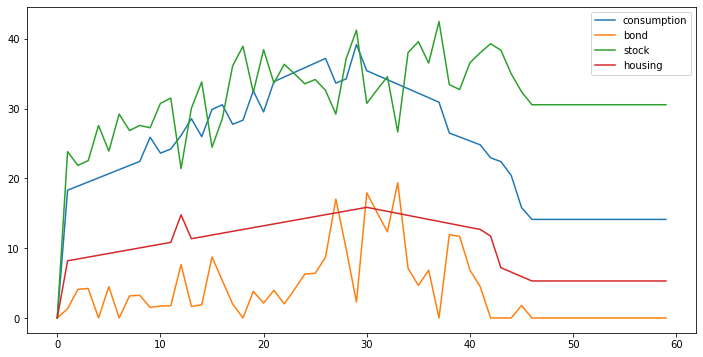

In [9]:
# plot consumption against time 
wealthLevel = 50
econState = 5
plt.figure(figsize = [12,6])
plt.plot(cgrid[wealthLevel,econState,:], label = "consumption")
plt.plot(bgrid[wealthLevel,econState,:], label = "bond")
plt.plot(kgrid[wealthLevel,econState,:], label = "stock")
plt.plot(hgrid[wealthLevel,econState,:]*pr, label = "housing")
legend()